# Implements

In [1]:
import os
from pathlib import Path
import numpy as np
# from keras import backend as K
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# GPU 메모리 사용 설정
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# 사용 가능한 GPU 장치 목록 출력
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

Num GPUs Available: 1


In [4]:
from tensorflow.python.client import device_lib

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6731080504266346087
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22707961856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8333784572867188208
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

classes = ["CONV", "HAMMING", "PRODUCT", "POLAR", "BCH", "RM", "GOLAY"]
snrs = list(range(-5, 21, 1))

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Define Funtions

## Base Settings

In [21]:
def train(model):
    resume = True
    filepath = "best_model.keras"  # 저장할 모델 파일명
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
    callbacks_list = [checkpoint, earlystopping]
    history = model.fit(x_train, y_train, epochs=100, batch_size=256, verbose=1, # batch_size=1024 -> 256
                            # validation_data=(x_test, y_test),
                            validation_data=(x_val, y_val),
                            callbacks=callbacks_list)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Baseline Error: %.2f%%' % (100 - score[1] * 100))
    
    return history

In [22]:
def test(model):
    acc = {}
    for snr in snrs:
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = x_test[np.where(np.array(test_SNRs) == str(snr))]
        test_Y_i = y_test[np.where(np.array(test_SNRs) == str(snr))]
        
        print(test_X_i)
        print(test_X_i.shape)
                
        print(f"\nTesting at SNR {snr} dB:")
        test_Y_i_hat = model.predict(test_X_i)
        
        conf = np.zeros([len(classes), len(classes)])
        for i in range(test_X_i.shape[0]):
            j = list(test_Y_i[i, :]).index(1)
            k = int(np.argmax(test_Y_i_hat[i, :]))
            conf[j, k] += 1
        
        confnorm = conf / np.sum(conf, axis=1, keepdims=True)
        
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        accuracy = cor / (cor + ncor)
        print(f"Overall Accuracy: {accuracy}")
        
        acc[snr] = accuracy
    
    # Plot accuracy by SNR
    plt.figure()
    plt.plot(snrs, [acc[snr] for snr in snrs], marker='o')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by SNR')
    plt.grid(True)
    plt.show()

In [23]:
def calc_confusion_matrix(model, x_test):
    y_predict = model.predict(x_test)

    # Calculate confusion matrix
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,x_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(y_predict[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    return confnorm

In [24]:
def plot_confusion_matrix(cm, results_dir, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    result_image_path = os.path.join(results_dir, 'conf_mat.png')
    plt.savefig(result_image_path)

In [94]:
def SNR_accuracy(in_snr, model, name, x_test, y_test, results_dir):
    acc = []
    for snr in in_snr:
        idx_acc_snr = [i for i in range(len(test_idx)) if lbl[test_idx[i]][1] == str(snr)]
        acc_X_test = x_test[idx_acc_snr]
        acc_Y_test = y_test[idx_acc_snr]
        
        print('\nSNR ' + str(snr) + 'dB:')
        accuracy_snr = model.evaluate(acc_X_test, acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)
    acc = np.vstack(acc)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize=15, label=name, linestyle='-')
    ax.legend(loc=4, prop={'size': 25})
    
    ax.set_xticks(np.arange(-5, 21, 1))
    ax.set_yticks(np.arange(0, 101, 10))
    
    ax.grid(which='both', color='lightgray', linestyle='-')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    
    ax.set_xlim(-5, 21)
    ax.set_ylim(0, 100)
    
    ax.set_title("Classification Accuracy", fontsize=20)
    ax.set_ylabel('Accuracy (%)', fontsize=20)
    ax.set_xlabel('SNR (dB)', fontsize=20)
    
    result_image_path = os.path.join(results_dir, 'snr_acc.png')
    plt.savefig(result_image_path)
    
    plt.show()

    return acc[:,1]

## Residual Block

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

## VGG Block

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def vgg_block(x, num_convs, filters):
    for _ in range(num_convs):
        x = layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    return x

# Load Dataset

In [17]:
current_dir = Path('Recognition_2.ipynb').parent

DATASET_DIR = 'DATASET_32X32'

base_dir = current_dir / DATASET_DIR

x_train = np.load(base_dir / "x_train.npy", allow_pickle=True)
y_train = np.load(base_dir / "y_train.npy", allow_pickle=True)

x_test = np.load(base_dir / "x_test.npy", allow_pickle=True)
y_test = np.load(base_dir / "y_test.npy", allow_pickle=True)

x_val = np.load(base_dir / "x_val.npy", allow_pickle=True)
y_val = np.load(base_dir / "y_val.npy", allow_pickle=True)

lbl = np.load(base_dir / "lbl.npy", allow_pickle=True).tolist()
train_idx = np.load(base_dir / "train_idx.npy", allow_pickle=True).tolist()
test_idx = np.load(base_dir / "test_idx.npy", allow_pickle=True).tolist()
val_idx = np.load(base_dir / "val_idx.npy", allow_pickle=True).tolist()

filepath = base_dir / "best_model.keras"

### Check Dataset shape

In [18]:
print(x_train.shape)

print(x_train[0])

(72800, 32, 32)
[[0. 1. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 1.]
 ...
 [1. 1. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


# Model

In [26]:
input_shape=(32, 32, 1)

## CNN

In [43]:
cnn_in = Input(shape=input_shape)

cnn = Conv2D(filters=64, kernel_size=(4, 4), activation='relu', name='conv2d_1')(cnn_in) 
cnn = Dropout(rate=0.2, name='dropout_1')(cnn)

cnn = Conv2D(filters=32, kernel_size=(4, 4), activation='relu', name='conv2d_2')(cnn) 
cnn = Dropout(rate=0.2, name='dropout_2')(cnn)

cnn = Conv2D(filters=16, kernel_size=(4, 4), activation='relu', name='conv2d_3')(cnn) 
cnn = Dropout(rate=0.2, name='dropout_3')(cnn)

cnn = Flatten(name='flatten')(cnn)  
cnn = Dense(120, activation='relu', name='dense_1')(cnn)
cnn = Dense(60, activation='relu', name='dense_2')(cnn)

cnn_out = Dense(len(classes), activation='softmax', name='dense_output')(cnn)

model_cnn = Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        1088      
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        32800     
                                                                 
 dropout_2 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 16)        8208      
                                                                 
 dropout_3 (Dropout)         (None, 23, 23, 16)        0   

### 중간 레이어 결과 확인

In [50]:
# 중간 레이어 출력 시각화 함수 정의
def plot_intermediate_output(intermediate_outputs, layer_names):
    for intermediate_output, layer_name in zip(intermediate_outputs, layer_names):
        num_filters = intermediate_output.shape[-1]
        size = intermediate_output.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        
        for i in range(num_filters):
            x = intermediate_output[0, :, :, i]
            mean_x = x.mean()
            std_x = x.std()
            
            # 표준 편차가 0인 경우 처리
            if std_x != 0:
                x = (x - mean_x) / std_x
            else:
                x = x - mean_x
            
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            display_grid[:, i * size : (i + 1) * size] = x
        
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

In [56]:
model_cnn.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test))

1950/1950 [==============================] - 8s 4ms/step - loss: 1.0987 - accuracy: 0.3325 - val_loss: 1.0993 - val_accuracy: 0.3279


1/1 [==============================] - 0s 45ms/step


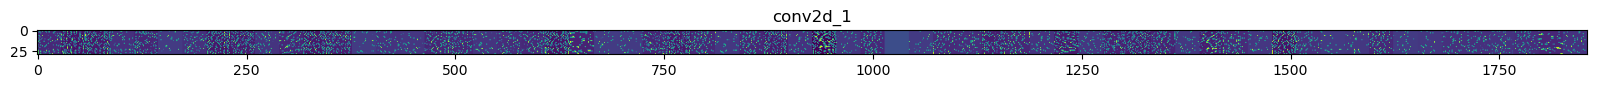

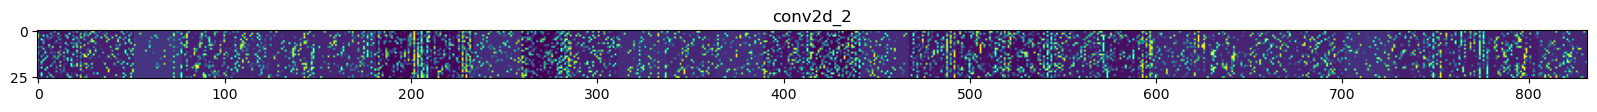

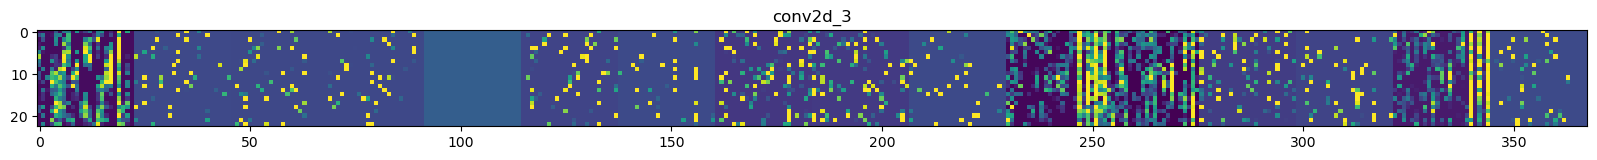

In [68]:
# 중간 레이어 출력을 추출하는 모델 정의
layer_outputs = [model_cnn.get_layer('conv2d_1').output,
                 model_cnn.get_layer('conv2d_2').output,
                 model_cnn.get_layer('conv2d_3').output]

intermediate_model = Model(inputs=model_cnn.input, outputs=layer_outputs)

# 테스트 데이터의 첫 번째 샘플에 대해 중간 레이어 출력 계산
sample_input = x_test[:1]
intermediate_outputs = intermediate_model.predict(sample_input)

# 중간 레이어 출력 시각화
layer_names = ['conv2d_1', 'conv2d_2', 'conv2d_3']
plot_intermediate_output(intermediate_outputs, layer_names)

## ResNet

In [77]:
ResNet_inputs = tf.keras.Input(shape=input_shape)
ResNet = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')(ResNet_inputs)
ResNet = layers.BatchNormalization()(ResNet)
ResNet = layers.ReLU()(ResNet)
ResNet = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(ResNet)

ResNet = residual_block(ResNet, 64)
ResNet = residual_block(ResNet, 64)

ResNet = residual_block(ResNet, 128, stride=2)
ResNet = residual_block(ResNet, 128)

ResNet = residual_block(ResNet, 256, stride=2)
ResNet = residual_block(ResNet, 256)

ResNet = residual_block(ResNet, 512, stride=2)
ResNet = residual_block(ResNet, 512)

ResNet = layers.GlobalAveragePooling2D()(ResNet)
ResNet_outputs = layers.Dense(len(classes), activation='softmax')(ResNet)

model_ResNet = models.Model(ResNet_inputs, ResNet_outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_ResNet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_ResNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   3200        ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]

## VGG19

In [98]:
VGG19_inputs = tf.keras.Input(shape=input_shape)

# Block 1
x = vgg_block(VGG19_inputs, num_convs=2, filters=64)

# Block 2
x = vgg_block(x, num_convs=2, filters=128)

# Block 3
x = vgg_block(x, num_convs=4, filters=256)

# Block 4
x = vgg_block(x, num_convs=4, filters=512)

# Block 5
x = vgg_block(x, num_convs=4, filters=512)

# Fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)

VGG19_outputs = layers.Dense(len(classes), activation='softmax')(x)

model_VGG19 = models.Model(VGG19_inputs, VGG19_outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_VGG19.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_VGG19.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 128)       147584    
                                                           

In [97]:
# model_VGG19.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test))

 627/2275 [=======>......................] - ETA: 22s - loss: 2.1060 - accuracy: 0.1464

KeyboardInterrupt: 

1/1 [==============================] - 0s 133ms/step


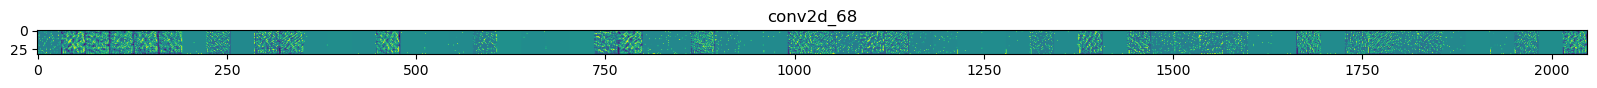

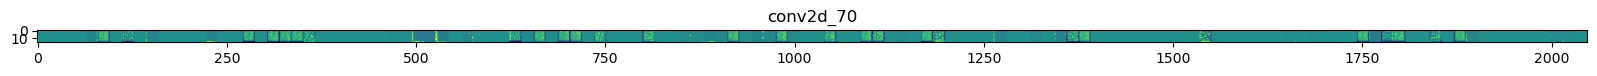

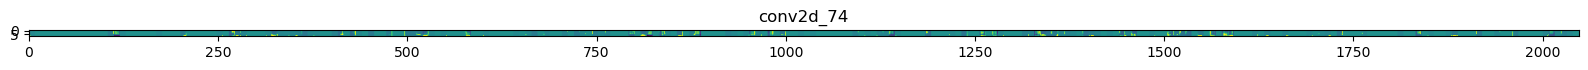

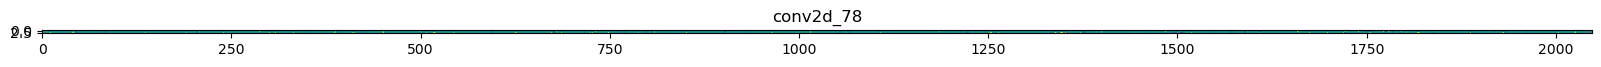

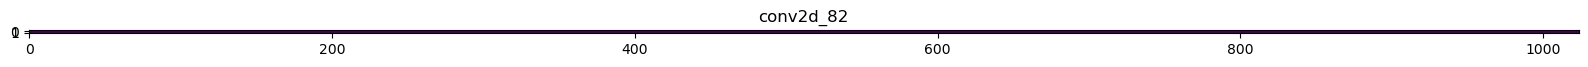

In [ ]:
# 필요한 Conv2D 레이어의 인덱스를 리스트로 정의
indices_to_visualize = [1, 3, 7, 11, 15]

# 해당 인덱스의 레이어 이름을 추출
layer_names_to_visualize = [layer_names[idx] for idx in indices_to_visualize]

# 각 레이어의 출력을 추출하는 모델 정의
layer_outputs_to_visualize = [model_VGG19.get_layer(layer_name).output for layer_name in layer_names_to_visualize]
intermediate_model_to_visualize = models.Model(inputs=model_VGG19.input, outputs=layer_outputs_to_visualize)

# 테스트 데이터의 첫 번째 샘플에 대해 중간 레이어 출력 계산
sample_input = x_test[:1]
intermediate_outputs_to_visualize = intermediate_model_to_visualize.predict(sample_input)

# 중간 레이어 출력 시각화
plot_intermediate_output(intermediate_outputs_to_visualize, layer_names_to_visualize)


## VGGNet >> 변형

In [80]:
VGGNet_inputs = tf.keras.Input(shape=input_shape)

# Block 1
x = vgg_block(VGGNet_inputs, num_convs=1, filters=64)

# Block 2
x = vgg_block(x, num_convs=1, filters=128)

# Block 3
x = vgg_block(x, num_convs=2, filters=256)

# Block 4
x = vgg_block(x, num_convs=2, filters=512)

# Block 5
x = vgg_block(x, num_convs=2, filters=512)

# Fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)

VGGNet_outputs = layers.Dense(len(classes), activation='softmax')(x)

model_VGGNet = models.Model(VGGNet_inputs, VGGNet_outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_VGGNet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_VGGNet.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 8, 8, 256)         295

1/1 [==============================] - 0s 78ms/step


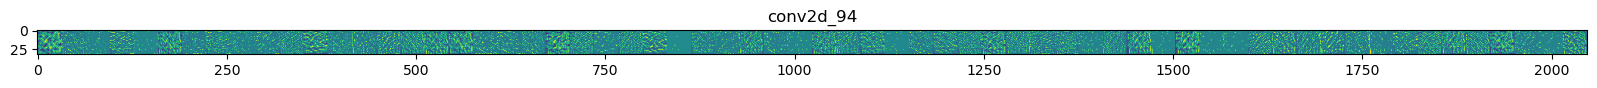

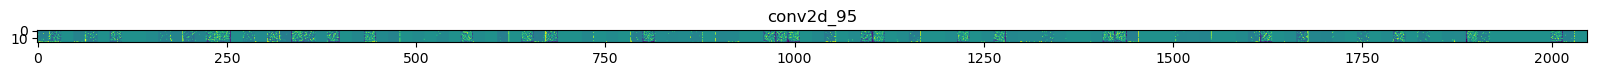

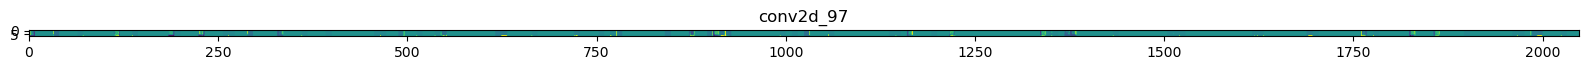

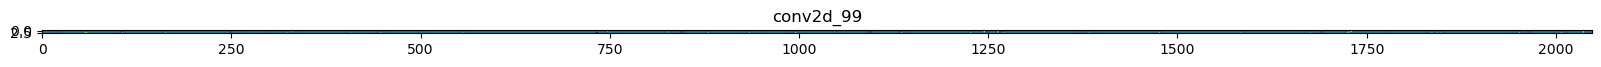

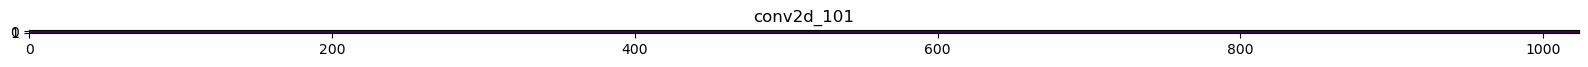

In [83]:
layer_names = []
for layer in model_VGGNet.layers:
    if 'conv2d' in layer.name:
        layer_names.append(layer.name)

# 필요한 Conv2D 레이어의 인덱스를 리스트로 정의
indices_to_visualize = [0, 1, 3, 5, 7]

# 해당 인덱스의 레이어 이름을 추출
layer_names_to_visualize = [layer_names[idx] for idx in indices_to_visualize]

# 각 레이어의 출력을 추출하는 모델 정의
layer_outputs_to_visualize = [model_VGGNet.get_layer(layer_name).output for layer_name in layer_names_to_visualize]
intermediate_model_to_visualize = models.Model(inputs=model_VGGNet.input, outputs=layer_outputs_to_visualize)

# 테스트 데이터의 첫 번째 샘플에 대해 중간 레이어 출력 계산
sample_input = x_test[:1]
intermediate_outputs_to_visualize = intermediate_model_to_visualize.predict(sample_input)

# 중간 레이어 출력 시각화
plot_intermediate_output(intermediate_outputs_to_visualize, layer_names_to_visualize)

# Train Model

In [99]:
# history = train(model_cnn)

# history = train(model_ResNet)

history = train(model_VGG19)

# history = train(model_VGGNet)

Epoch 1/100
285/285 [==============================] - ETA: 0s - loss: 1.9906 - accuracy: 0.1448
Epoch 1: val_accuracy improved from -inf to 0.14308, saving model to best_model.keras
285/285 [==============================] - 15s 48ms/step - loss: 1.9906 - accuracy: 0.1448 - val_loss: 1.9459 - val_accuracy: 0.1431
Epoch 2/100
285/285 [==============================] - ETA: 0s - loss: 1.9461 - accuracy: 0.1416
Epoch 2: val_accuracy did not improve from 0.14308
285/285 [==============================] - 10s 36ms/step - loss: 1.9461 - accuracy: 0.1416 - val_loss: 1.9461 - val_accuracy: 0.1400
Epoch 3/100
285/285 [==============================] - ETA: 0s - loss: 1.9460 - accuracy: 0.1406
Epoch 3: val_accuracy did not improve from 0.14308
285/285 [==============================] - 10s 36ms/step - loss: 1.9460 - accuracy: 0.1406 - val_loss: 1.9462 - val_accuracy: 0.1400
Epoch 4/100
285/285 [==============================] - ETA: 0s - loss: 1.9460 - accuracy: 0.1430
Epoch 4: val_accuracy did

# Test Model

In [ ]:
# test(model_cnn)

# test(model_ResNet)

# test(model_VGG19)

# Plot Result

In [ ]:
import os
import datetime
import matplotlib.pyplot as plt

# 현재 시간을 기준으로 폴더 이름 생성
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_name = f"results_{current_time}"

# 결과를 저장할 폴더 경로 설정
current_dir = os.getcwd()  # 현재 작업 디렉토리
results_dir = os.path.join(current_dir, folder_name)

# 폴더 생성
os.makedirs(results_dir, exist_ok=True)

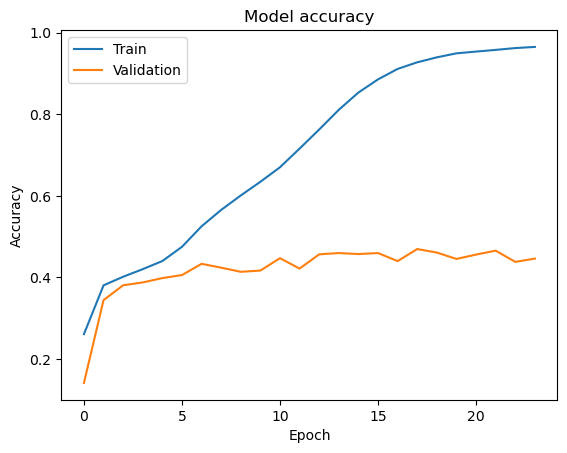

In [ ]:
# Acc의 추이 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

result_image_path = os.path.join(results_dir, 'acc_trends.png')
plt.savefig(result_image_path)

plt.show()

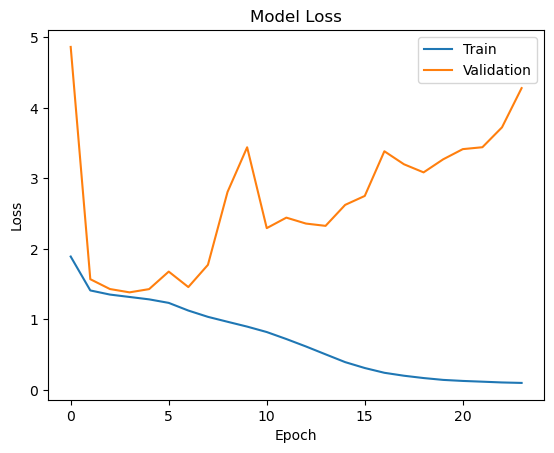

In [ ]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

result_image_path = os.path.join(results_dir, 'loss_trends.png')
plt.savefig(result_image_path)

plt.show()

285/285 [==============================] - 1s 4ms/step


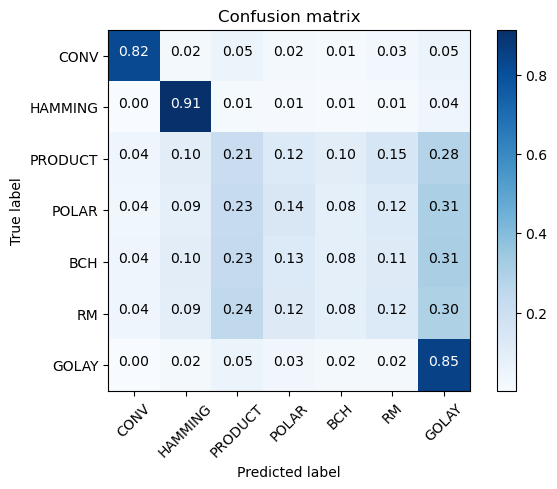

In [ ]:
# confnorm = calc_confusion_matrix(model_cnn, x_test)
# confnorm = calc_confusion_matrix(model_ResNet, x_test)
confnorm = calc_confusion_matrix(model_VGG19, x_test)
# confnorm = calc_confusion_matrix(model_VGGNet, x_test)

# Plot confusion matrix
plot_confusion_matrix(confnorm, results_dir, labels=classes)


SNR -5dB:
12/12 - 0s - loss: 4.2182 - accuracy: 0.4915 - 114ms/epoch - 9ms/step

SNR -4dB:
11/11 - 0s - loss: 4.8334 - accuracy: 0.3789 - 65ms/epoch - 6ms/step

SNR -3dB:
11/11 - 0s - loss: 4.5725 - accuracy: 0.4071 - 91ms/epoch - 8ms/step

SNR -2dB:
12/12 - 0s - loss: 3.9995 - accuracy: 0.4876 - 97ms/epoch - 8ms/step

SNR -1dB:
12/12 - 0s - loss: 3.3661 - accuracy: 0.5071 - 107ms/epoch - 9ms/step

SNR 0dB:
10/10 - 0s - loss: 4.0914 - accuracy: 0.4371 - 90ms/epoch - 9ms/step

SNR 1dB:
11/11 - 0s - loss: 4.1837 - accuracy: 0.4257 - 66ms/epoch - 6ms/step

SNR 2dB:
12/12 - 0s - loss: 4.3487 - accuracy: 0.4429 - 96ms/epoch - 8ms/step

SNR 3dB:
13/13 - 0s - loss: 4.0138 - accuracy: 0.4338 - 73ms/epoch - 6ms/step

SNR 4dB:
12/12 - 0s - loss: 4.3795 - accuracy: 0.3978 - 94ms/epoch - 8ms/step

SNR 5dB:
11/11 - 0s - loss: 4.4669 - accuracy: 0.4354 - 96ms/epoch - 9ms/step

SNR 6dB:
12/12 - 0s - loss: 4.0185 - accuracy: 0.4469 - 67ms/epoch - 6ms/step

SNR 7dB:
11/11 - 0s - loss: 4.3573 - accurac

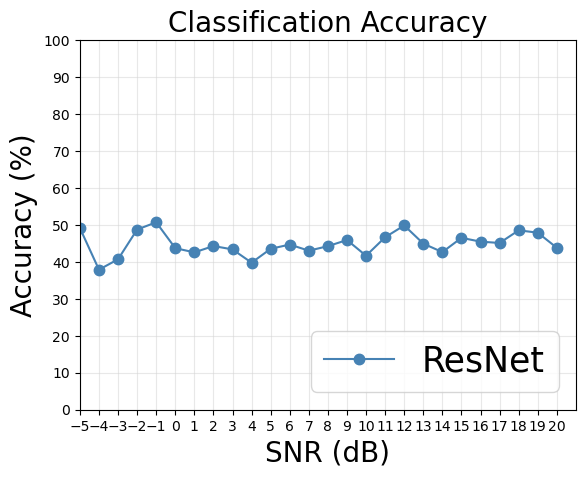

In [ ]:
# Plot classfication accuracy by each SNR
# acc = SNR_accuracy(snrs, model_cnn, 'CNN', x_test, y_test, results_dir)
# acc = SNR_accuracy(snrs, model_ResNet, 'ResNet', x_test, y_test, results_dir)
acc = SNR_accuracy(snrs, model_VGG19, 'VGG19', x_test, y_test, results_dir)
# acc = SNR_accuracy(snrs, model_VGGNet, 'VGG11', x_test, y_test, results_dir)